# Read aggregated results 
The collect_results.py script aggregates results from multiple directories. You can view and manipulate the aggregated results to get insights from the data

In [1]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import logging
import matplotlib
matplotlib._log.disabled = True
logging.basicConfig(level='CRITICAL')
# Turn off sina logging
for name in [
             "matplotlib", "matplotlib.font", "matplotlib.pyplot"]:
    logger = logging.getLogger(name)
    logger.setLevel(logging.CRITICAL)
    logger.disabled = True
    
import glob
import os
import json
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap
cmap_green_yellow_red = LinearSegmentedColormap.from_list(
    name='test', 
    colors=['green','yellow','red']
)


from scipy import stats
import time

import pandas as pd
from pandas import DataFrame

import sys
# add reference to the few_shot dir
path_base = os.path.abspath(os.path.join(sys.path[0], '../'))
print(path_base)
sys.path.insert(1, path_base)
from collect_results import view_preferred_metrics, get_first_candidates_prompts, get_first_pred_prompts_example

/private/home/tbmihaylov/fairseq-xlmg/examples/few_shot


Read the raw results file:

In [2]:
# This is the path to the raw results file generated with the script
results_json = "/private/home/tbmihaylov/fairseq-xlmg/gpt3_repro_cb_results.tsv.raw.jsonl"
results_json = "/private/home/tbmihaylov/fairseq-xlmg/cb_our_models.tsv.raw.jsonl"
#results_json = "/checkpoint/tbmihaylov/few_shot/xnli_experimental/results_200.tsv.raw.jsonl"

# python examples/few_shot/scripts/collect_results.py -i /checkpoint/tbmihaylov/few_shot/xnli_experimental/*smpl.All* -o /checkpoint/tbmihaylov/few_shot/xnli_experimental/results.tsv -v preferred_metrics_mean
results_json = "/checkpoint/tbmihaylov/few_shot/xnli_experimental/results.tsv.raw.jsonl"

#python examples/few_shot/scripts/collect_results.py -i /checkpoint/tbmihaylov/few_shot/2021_09_multilingual_eval_v1 -o /checkpoint/tbmihaylov/few_shot/2021_09_multilingual_eval_v1/results.tsv -v preferred_metrics_mean
results_json = "/checkpoint/tbmihaylov/few_shot/multilingual_xnli_1.3B_gpt3_setting_checkpoints/results.tsv.raw.jsonl"
# python examples/few_shot/scripts/collect_results.py -i /checkpoint/tbmihaylov/few_shot/2021_09_multilingual_eval_v1_full -o /checkpoint/tbmihaylov/few_shot/2021_09_multilingual_eval_v1_full/results.tsv -v preferred_metrics_mean
#results_json = "/checkpoint/tbmihaylov/few_shot/2021_09_multilingual_eval_v1_full/results.tsv.raw.jsonl"
#results_json = "/checkpoint/tbmihaylov/few_shot/2021_09_multilingual_eval_v1_full_calib/results.tsv.raw.jsonl"

# use the following script to recompute the results
# python examples/few_shot/scripts/collect_results.py -i /checkpoint/tbmihaylov/few_shot/2021-09-15-multilingual_bigrun_eval_v1_extended -o /checkpoint/tbmihaylov/few_shot/2021-09-15-multilingual_bigrun_eval_v1_extended/results.tsv -r 
results_json = "/checkpoint/tbmihaylov/few_shot/2021-09-15-multilingual_bigrun_eval_v1_extended/results.tsv.raw.jsonl"
results_json = "/large_experiments/xlmg/results/multilingual/dense_7_5B_30lang_cpts/results.tsv.raw.jsonl"

In [3]:
only_monolingual = False 

results = []
with open(results_json) as f_res:
    for line in f_res:
        line = line.strip()
        item = json.loads(line)
        if 'run_params::n_eval_samples' not in item:
            item['run_params::n_eval_samples'] = 0
        if item['run_params::n_eval_samples'] != 0:
            continue
        
        item['eval_examples_cnt'] = int(item.get('eval_examples_cnt::mean', item['run_params::n_eval_samples']))
        
        for k in list(item.keys()):
            if k.startswith("ppl_candidates_full_prompt__"):
                del item[k]
                
        if only_monolingual and item["train_lang"] != item["language"]:
            continue
        results.append(item)

print(f"{len(results)} items loaded")
#print(item)

356 items loaded


In [4]:
df = DataFrame.from_records(results)

The results has the followinf columns:

In [5]:
list(df.columns)

['model_name',
 'task',
 'language',
 'template',
 'nb_few_shot_samples',
 'calibration_options',
 'calibrator_name',
 'train_set',
 'valid_set',
 'eval_set',
 'train_lang',
 'valid_lang',
 'ppl_common_prefix::scores',
 'ppl_common_prefix::mean',
 'ppl_common_prefix::std',
 'ppl_common_prefix::mean_confidence_interval',
 'ppl_selected_candidate::scores',
 'ppl_selected_candidate::mean',
 'ppl_selected_candidate::std',
 'ppl_selected_candidate::mean_confidence_interval',
 'ppl_full_selected_candidate::scores',
 'ppl_full_selected_candidate::mean',
 'ppl_full_selected_candidate::std',
 'ppl_full_selected_candidate::mean_confidence_interval',
 'ppl_candidates_full_prompt::scores',
 'ppl_candidates_full_prompt::mean',
 'ppl_candidates_full_prompt::std',
 'ppl_candidates_full_prompt::mean_confidence_interval',
 'ppl_candidates::scores',
 'ppl_candidates::mean',
 'ppl_candidates::std',
 'ppl_candidates::mean_confidence_interval',
 'accuracy::scores',
 'accuracy::mean',
 'accuracy::std',
 'ac

## Print template verbalized prompts

In [6]:
print("Verbalized examples:")
print("#" * 10)
for item in results:
    verbalized_prompt = get_first_pred_prompts_example(item["results_file"])
    verablization_info = f"task:{item['task']} nshot={item['nb_few_shot_samples']} template: {item['template']}:\n{verbalized_prompt}"
    item["verbalization"] = verablization_info
    if item["language"] == "en":
        print(verablization_info)
        print("")
        

Verbalized examples:
##########
task:storycloze nshot=0 template: storycloze:
### Prompt for cand `He is happy now.`:
Rick grew up in a troubled household. He never found good support in family, and turned to gangs. It wasn't long before Rick got shot in a robbery. The incident caused him to turn a new leaf. He is happy now.
##########

task:pawsx nshot=0 template: pawsx_mt:
### Prompt for cand `true`:
Sentence 1: From the merger of the Four Rivers Council and the Audubon Council, the Shawnee Trails Council was born. Sentence 2: Shawnee Trails Council was formed from the merger of the Four Rivers Council and the Audubon Council. Sentence 1 and Sentence 2 have the same meaning. True or False? True
##########
### Calibrations prompts for cand `true`:
## calib option 0 prompt:
Sentence 2: Shawnee Trails Council was formed from the merger of the Four Rivers Council and the Audubon Council. Sentence 1 and Sentence 2 have the same meaning. True or False? True

task:pawsx nshot=0 template: pa

# Create a custom view using pandas
You can use the pandas api to manipulate the table and create custom views. 

In [7]:
def view_preferred_metrics_mean(df):
    run_columns = ["task", "eval_set", "eval_examples_cnt", "language", "train_set", "train_lang", "template", "nb_few_shot_samples", "calibration", "run_params::scoring", "model_name"]
    suffixes = ["::mean", "::std"]
    
    return view_preferred_metrics(df, run_columns, suffixes)

df_selected = df # view_preferred_metrics_mean(df)

value_cols_all = ["accuracy_run_ensemble", "accuracy::mean", "accuracy_sum_calib::mean", "accuracy_mean_calib::mean", "accuracy_mean::mean", "accuracy_sum::mean", "accuracy__raw::mean"]
value_cols = [x for x in value_cols_all if x in df_selected.columns]
index_cols = ["calibration", "task", "eval_set", "eval_examples_cnt", "train_set", "nb_few_shot_samples", 
              "template","model_name", 
             ]
cols = ["language"]
pt = pd.pivot_table(df_selected, values=value_cols, index=index_cols,
                    columns=cols, aggfunc=[np.mean])
pt = pt.swaplevel(1, 2, axis=1).sort_index(axis=1)

output_tsv = results_json + ".formatted.tsv"
pt.to_csv(output_tsv, sep="\t")
print("Open the following file in gsheets to see the full table:")
print(output_tsv)
pt

Open the following file in gsheets to see the full table:
/large_experiments/xlmg/results/multilingual/dense_7_5B_30lang_cpts/results.tsv.raw.jsonl.formatted.tsv


mean  \
language                                                                                                                                                                      ar   
                                                                                                                                                                  accuracy::mean   
calibration task       eval_set eval_examples_cnt train_set nb_few_shot_samples template                       model_name                                                          
False       storycloze val2016  1871              val2016   0                   storycloze                     dense_7.5B_lang30_new_cc100_xl_unigram__step000...      49.652592   
                                                                                                               dense_7.5B_lang30_new_cc100_xl_unigram__step000...      52.378407   
                                                                                                               dense_7.5B_lang30_new_cc100_xl_unigram__step000...      54.676644   
                                                                                                               dense_7.5B_lang30_new_cc100_xl_unigram__step000...      55.050775   
                                                                                                               dense_7.5B_lang30_new_cc100_xl_unigram__step000...      55.799038   
...                                                                                                                                                                          ...   
True        xnli       dev      2490              test      0                   xnli_generativenli_sentence_mt dense_7.5B_lang30_new_cc100_xl_unigram__step000...      34.819277   
                                                                                                               dense_7.5B_lang30_new_cc100_xl_unigram__step000...            NaN   
                                                                                                               dense_7.5B_lang30_new_cc100_xl_unigram__step000...            NaN   
                                                                                                               dense_7.5B_lang30_new_cc100_xl_unigram__step000...      35.702811   
                                                                                                               dense_7.5B_lang30_new_cc100_xl_unigram__step000...      34.698795   

                                                                                                                                                                                       \
language                                                                                                                                                                                
                                                                                                                                                                  accuracy__raw::mean   
calibration task       eval_set eval_examples_cnt train_set nb_few_shot_samples template                       model_name                                                               
False       storycloze val2016  1871              val2016   0                   storycloze                     dense_7.5B_lang30_new_cc100_xl_unigram__step000...            0.496526   
                                                                                                               dense_7.5B_lang30_new_cc100_xl_unigram__step000...            0.523784   
                                                                                                               dense_7.5B_lang30_new_cc100_xl_unigram__step000...            0.546766   
                                                                                                               dense_7.5B_lang30_new_cc100_xl_unigram__step000...            0.5

Demonstration of recommended significant difference (current signif. diff than compared) 
 n1=n2=1000 examples, stat_power=0.85 , sig_level=0.05
[(0.33, 0.269), (0.34, 0.278), (0.35, 0.288), (0.36, 0.297), (0.37, 0.307), (0.38, 0.316), (0.39, 0.326), (0.4, 0.335), (0.41, 0.345), (0.42, 0.355), (0.43, 0.364), (0.44, 0.374), (0.45, 0.384), (0.46, 0.394), (0.47, 0.404), (0.48, 0.413), (0.49, 0.423), (0.5, 0.433), (0.51, 0.443), (0.52, 0.453), (0.53, 0.463), (0.54, 0.473), (0.55, 0.483), (0.56, 0.493), (0.57, 0.503), (0.58, 0.513), (0.59, 0.523), (0.6, 0.534), (0.61, 0.544), (0.62, 0.554), (0.63, 0.564), (0.64, 0.575), (0.65, 0.585), (0.66, 0.595), (0.67, 0.606), (0.68, 0.616), (0.69, 0.627), (0.7, 0.637), (0.71, 0.647), (0.72, 0.658), (0.73, 0.669), (0.74, 0.679), (0.75, 0.69), (0.76, 0.701), (0.77, 0.711), (0.78, 0.722), (0.79, 0.733), (0.8, 0.744), (0.81, 0.755), (0.82, 0.766), (0.83, 0.777), (0.84, 0.788), (0.85, 0.799), (0.86, 0.81), (0.87, 0.822), (0.88, 0.833), (0.89, 0.845), (0.9, 

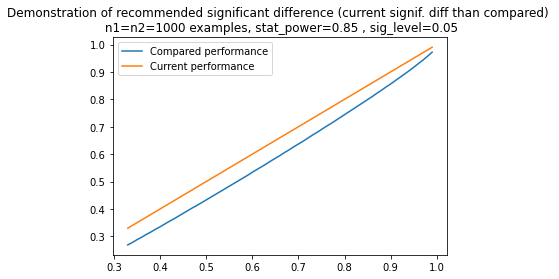

In [8]:
from examples.few_shot.scripts.significance_test import ProportionSignificanceTest

n_demo = 1000
max_sig_level = 0.05
min_stat_power = 0.85
a = [(i/100, np.round(ProportionSignificanceTest().solve(
            n1=n_demo, n2=n_demo , p1=i/100.0, p2=None, power=min_stat_power, sig_level=max_sig_level
),3)) for i in range(33, 100)]

x,y = zip(*a)
plt.plot(x, y, label='Compared performance')
plt.plot(x, x, label='Current performance')
plt.legend()
demo_title = f"Demonstration of recommended significant difference (current signif. diff than compared) \n n1=n2={n_demo} examples, stat_power={min_stat_power} , sig_level={max_sig_level}"
plt.title(demo_title)
print(demo_title)
print(a)




xnli
(True, 'xnli', 'dev', 2490, 'test', 0, 'xnli_generativenli_sentence_mt', 'ar')


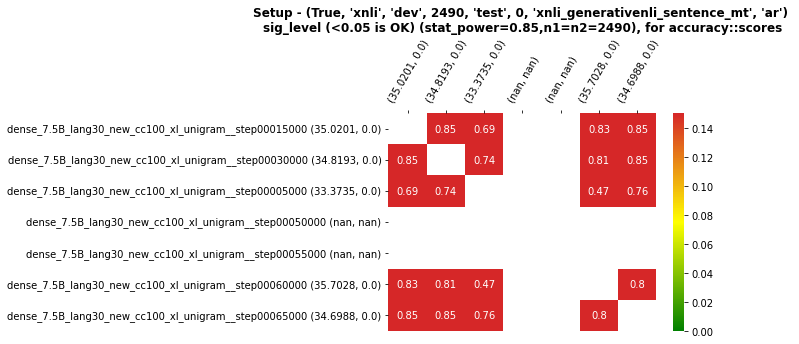

(True, 'xnli', 'dev', 2490, 'test', 0, 'xnli_generativenli_sentence_mt', 'bg')


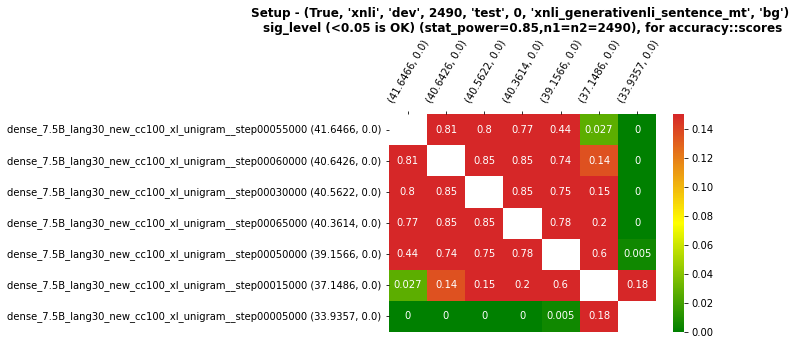

(True, 'xnli', 'dev', 2490, 'test', 0, 'xnli_generativenli_sentence_mt', 'de')


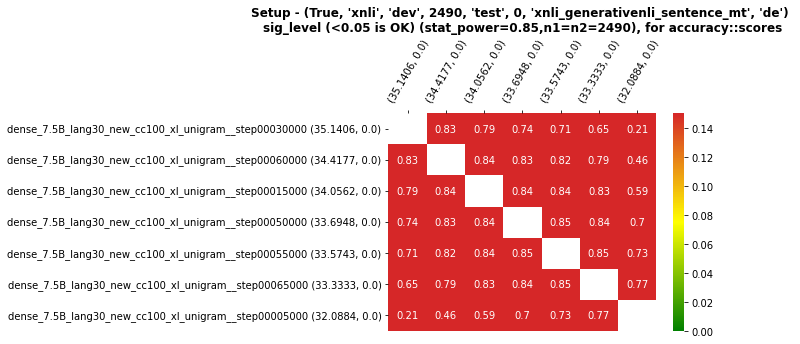

(True, 'xnli', 'dev', 2490, 'test', 0, 'xnli_generativenli_sentence_mt', 'el')


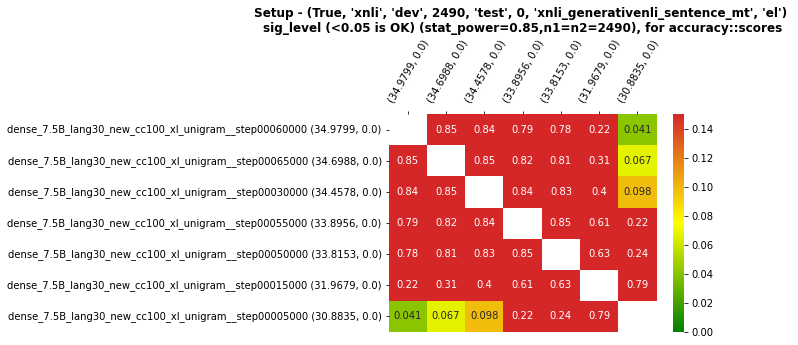

(True, 'xnli', 'dev', 2490, 'test', 0, 'xnli_generativenli_sentence_mt', 'en')
p1=0.42851405622489963, p2=0.42851405622489963 - Cannot detect an effect-size of 0. Try changing your effect-size.
p1=0.3433734939759036, p2=0.4610441767068273 - f(a) and f(b) must have different signs


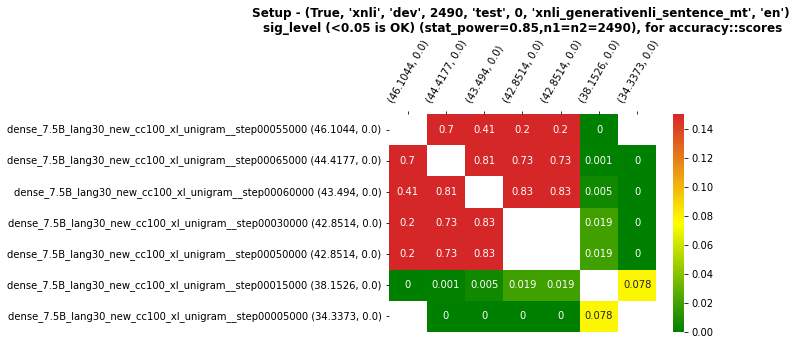

(True, 'xnli', 'dev', 2490, 'test', 0, 'xnli_generativenli_sentence_mt', 'es')


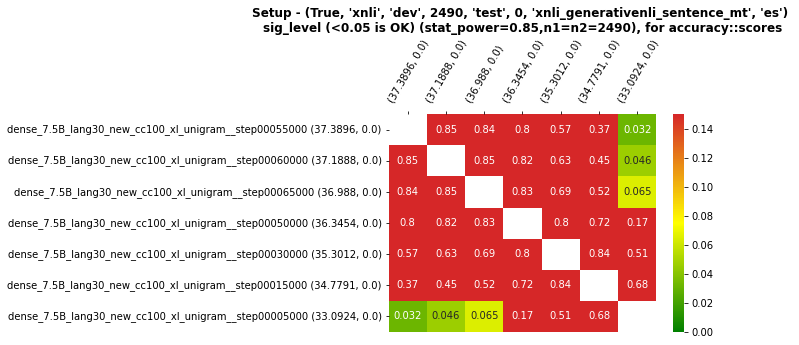

(True, 'xnli', 'dev', 2490, 'test', 0, 'xnli_generativenli_sentence_mt', 'fr')


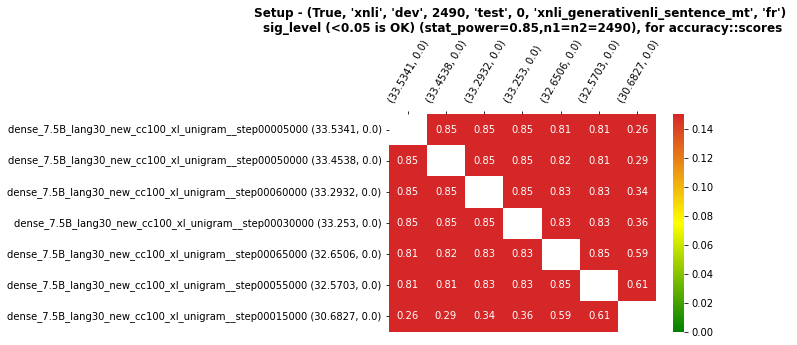

(True, 'xnli', 'dev', 2490, 'test', 0, 'xnli_generativenli_sentence_mt', 'ru')


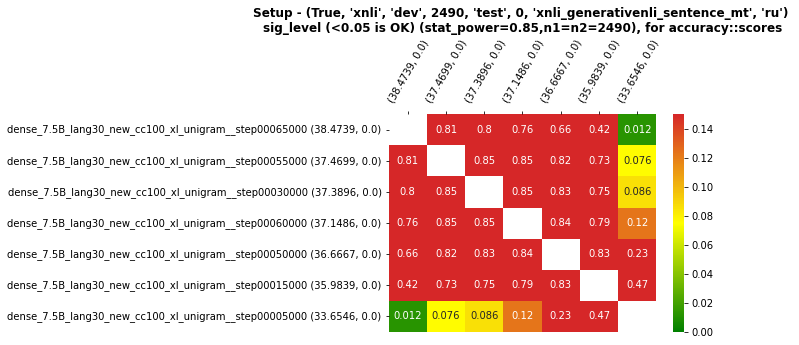

(True, 'xnli', 'dev', 2490, 'test', 0, 'xnli_generativenli_sentence_mt', 'tr')


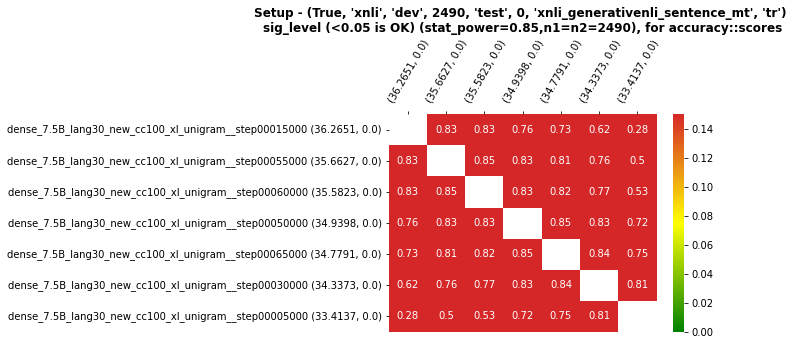

pawsx
(True, 'pawsx', 'dev', 2000, 'test', 0, 'pawsx_generativenli_ht', 'de')


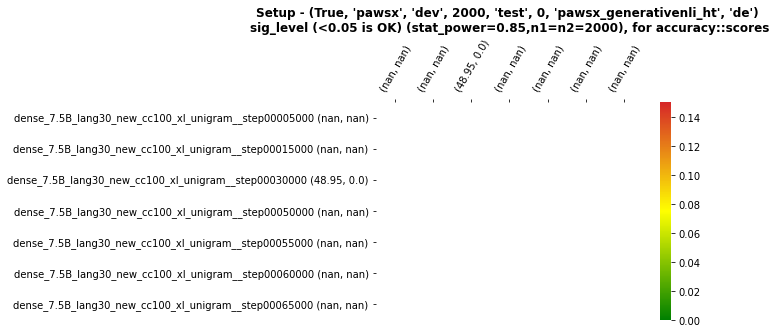

(True, 'pawsx', 'dev', 2000, 'test', 0, 'pawsx_generativenli_mt', 'de')
p1=0.586, p2=0.586 - Cannot detect an effect-size of 0. Try changing your effect-size.


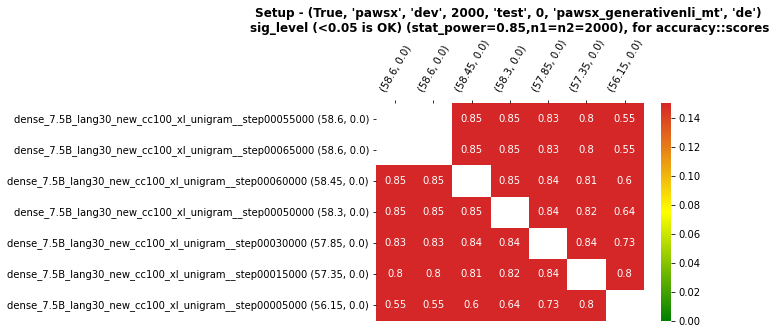

(True, 'pawsx', 'dev', 2000, 'test', 0, 'pawsx_generativenli_mt', 'en')
p1=0.555, p2=0.555 - Cannot detect an effect-size of 0. Try changing your effect-size.


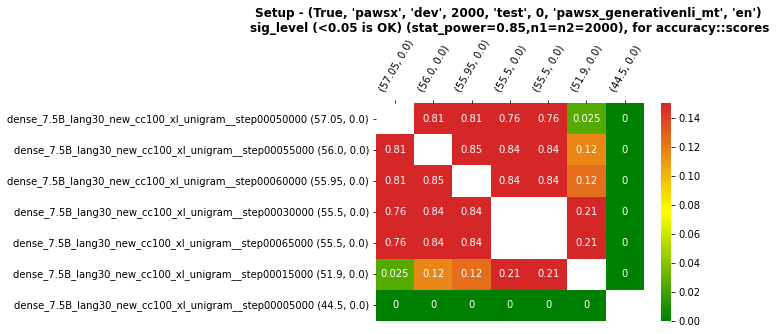

(True, 'pawsx', 'dev', 2000, 'test', 0, 'pawsx_generativenli_mt', 'es')


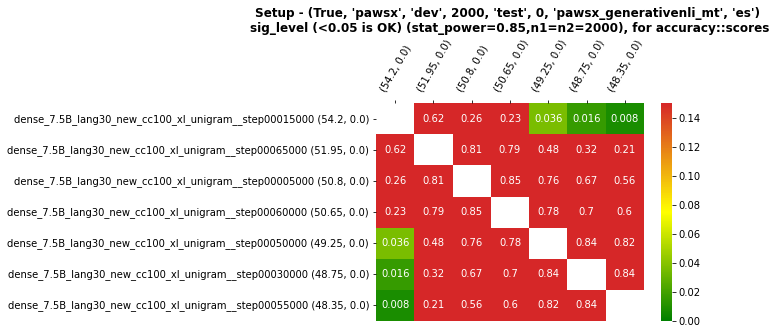

(True, 'pawsx', 'dev', 2000, 'test', 0, 'pawsx_generativenli_mt', 'fr')


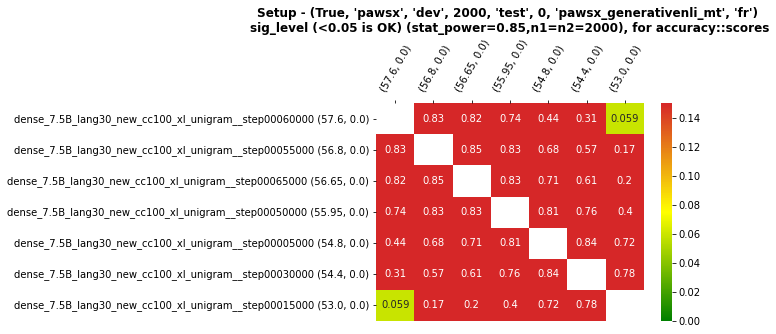

(True, 'pawsx', 'dev', 2000, 'test', 0, 'pawsx_generativenli_mt', 'ja')
p1=0.5705, p2=0.5705 - Cannot detect an effect-size of 0. Try changing your effect-size.


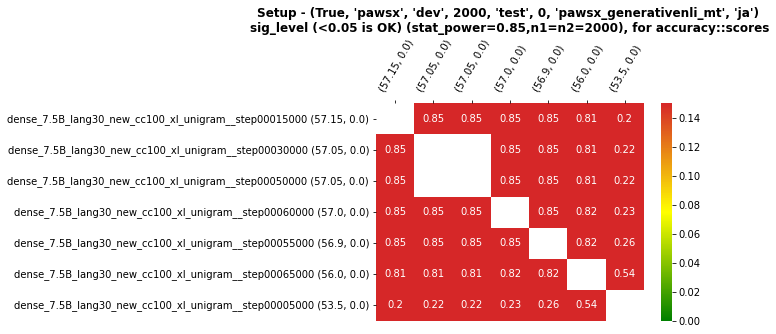

(True, 'pawsx', 'dev', 2000, 'test', 0, 'pawsx_generativenli_mt', 'ko')
p1=0.425, p2=0.575 - f(a) and f(b) must have different signs
p1=0.425, p2=0.574 - f(a) and f(b) must have different signs
p1=0.425, p2=0.563 - f(a) and f(b) must have different signs
p1=0.425, p2=0.557 - f(a) and f(b) must have different signs
p1=0.425, p2=0.5539999999999999 - f(a) and f(b) must have different signs


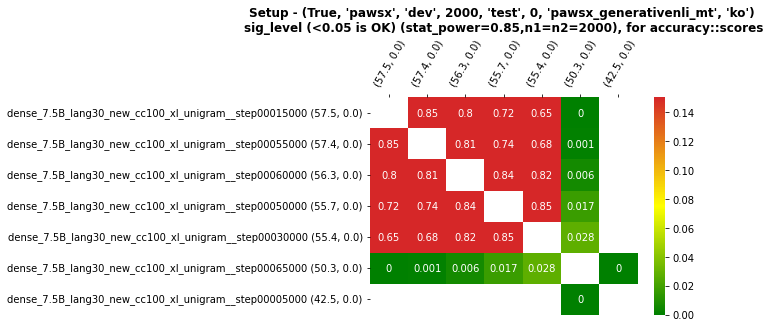

(True, 'pawsx', 'dev', 2000, 'test', 0, 'pawsx_generativenli_mt', 'zh')


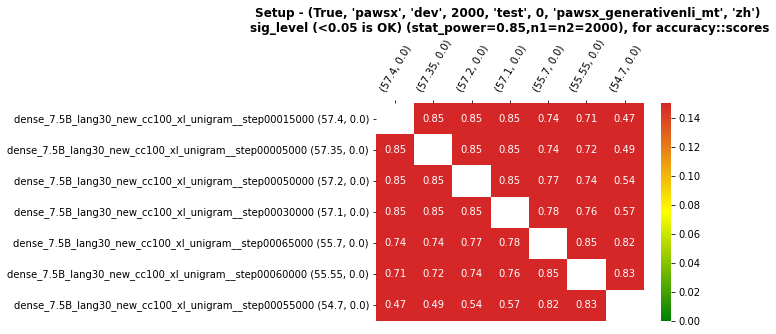

(True, 'pawsx', 'dev', 2000, 'test', 0, 'pawsx_mt', 'de')
p1=0.42100000000000004, p2=0.56 - f(a) and f(b) must have different signs


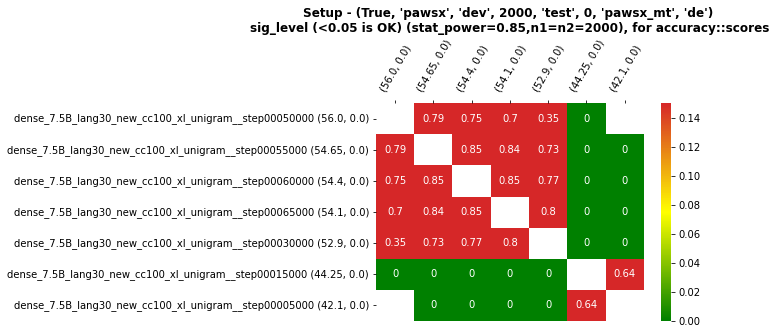

(True, 'pawsx', 'dev', 2000, 'test', 0, 'pawsx_mt', 'en')


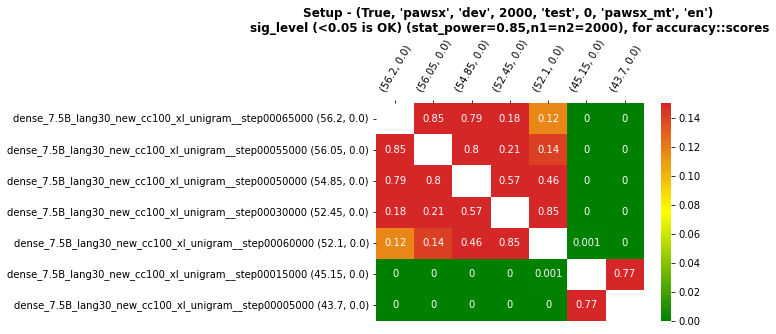

(True, 'pawsx', 'dev', 2000, 'test', 0, 'pawsx_mt', 'es')


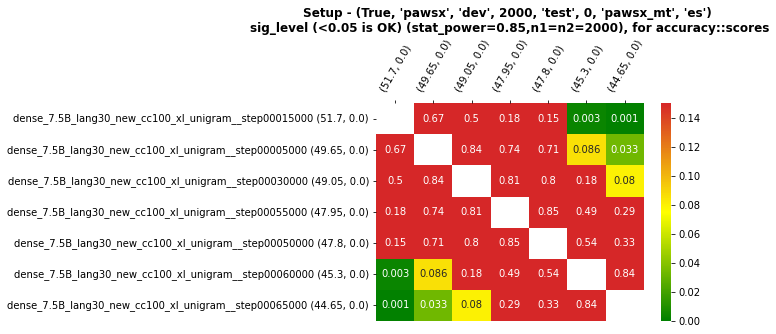

(True, 'pawsx', 'dev', 2000, 'test', 0, 'pawsx_mt', 'fr')


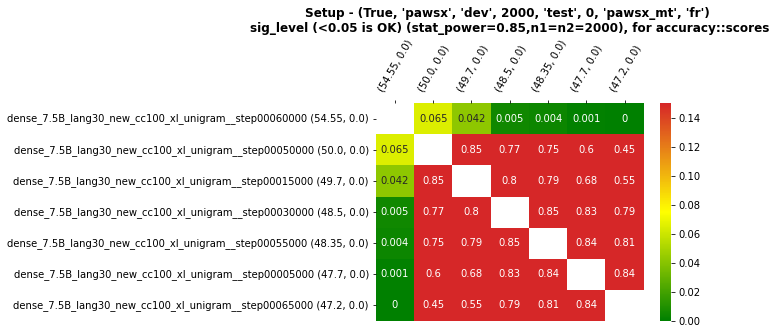

(True, 'pawsx', 'dev', 2000, 'test', 0, 'pawsx_mt', 'ja')


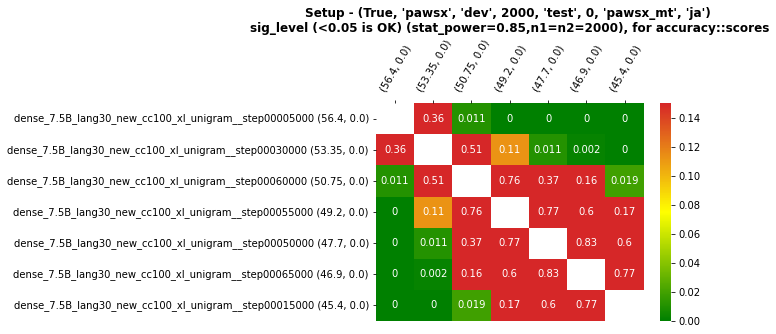

(True, 'pawsx', 'dev', 2000, 'test', 0, 'pawsx_mt', 'ko')


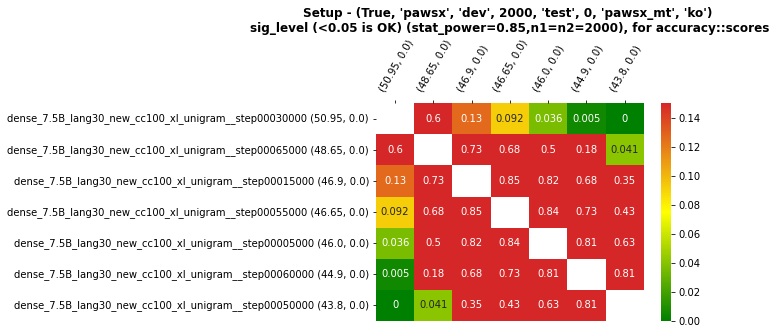

(True, 'pawsx', 'dev', 2000, 'test', 0, 'pawsx_mt', 'zh')
p1=0.4675, p2=0.4675 - Cannot detect an effect-size of 0. Try changing your effect-size.


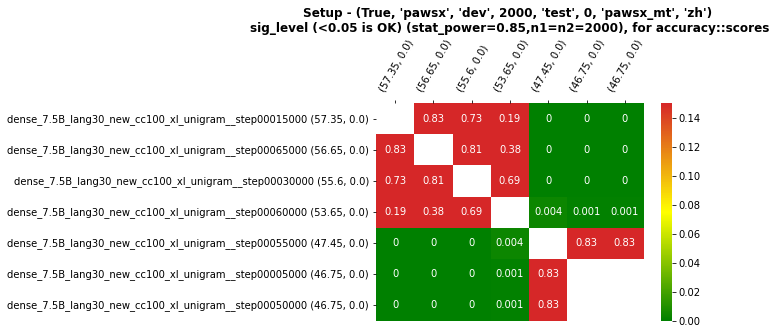

xcopa
(False, 'xcopa', 'val', 100, 'test', 0, 'xcopa', 'et')


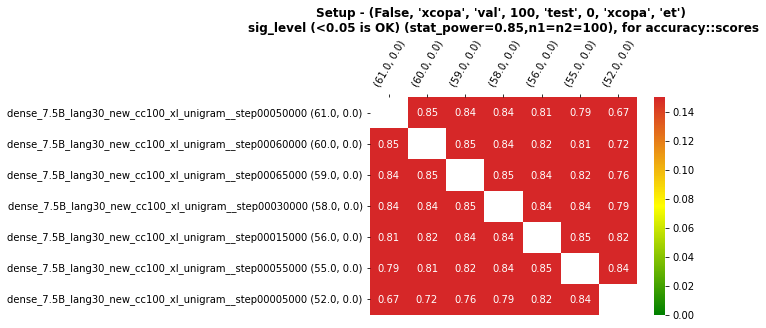

(False, 'xcopa', 'val', 100, 'test', 0, 'xcopa', 'ht')
p1=0.59, p2=0.59 - Cannot detect an effect-size of 0. Try changing your effect-size.
p1=0.54, p2=0.54 - Cannot detect an effect-size of 0. Try changing your effect-size.


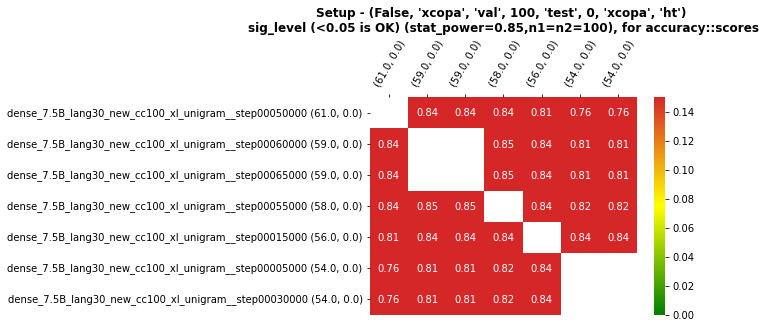

(False, 'xcopa', 'val', 100, 'test', 0, 'xcopa', 'id')
p1=0.59, p2=0.59 - Cannot detect an effect-size of 0. Try changing your effect-size.
p1=0.59, p2=0.59 - Cannot detect an effect-size of 0. Try changing your effect-size.
p1=0.59, p2=0.59 - Cannot detect an effect-size of 0. Try changing your effect-size.


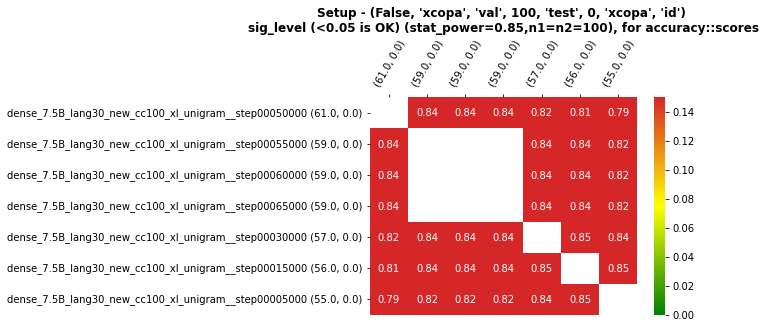

(False, 'xcopa', 'val', 100, 'test', 0, 'xcopa', 'it')
p1=0.59, p2=0.59 - Cannot detect an effect-size of 0. Try changing your effect-size.


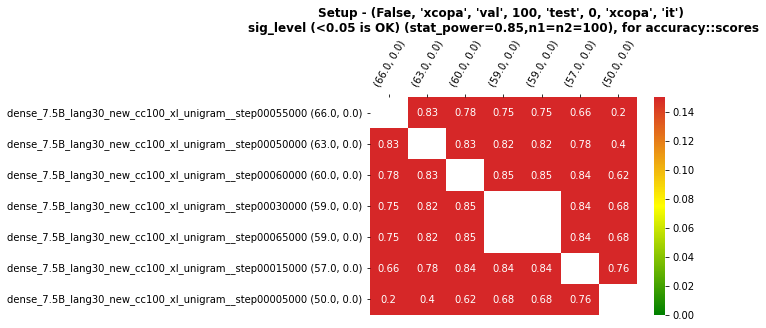

(False, 'xcopa', 'val', 100, 'test', 0, 'xcopa', 'qu')


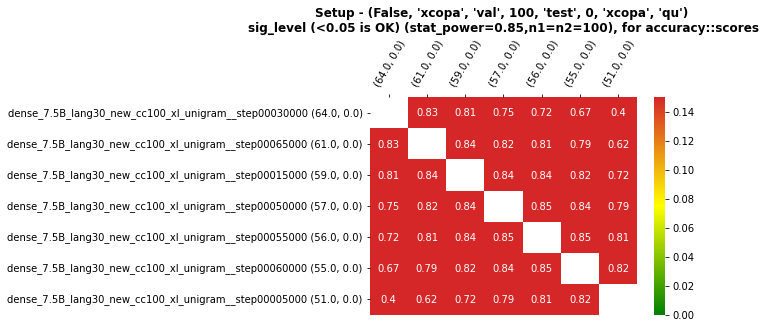

(False, 'xcopa', 'val', 100, 'test', 0, 'xcopa', 'ru')


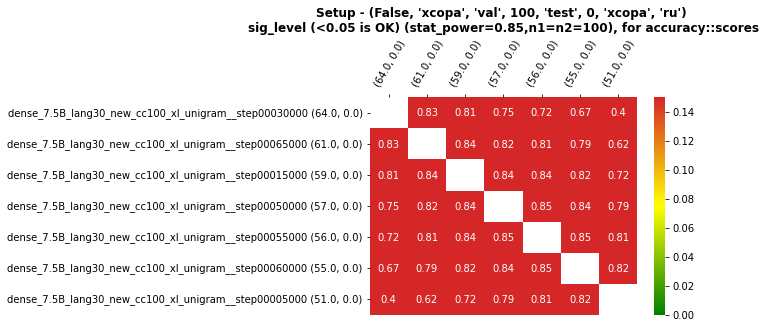

(False, 'xcopa', 'val', 100, 'test', 0, 'xcopa', 'sw')
p1=0.64, p2=0.64 - Cannot detect an effect-size of 0. Try changing your effect-size.
p1=0.61, p2=0.61 - Cannot detect an effect-size of 0. Try changing your effect-size.


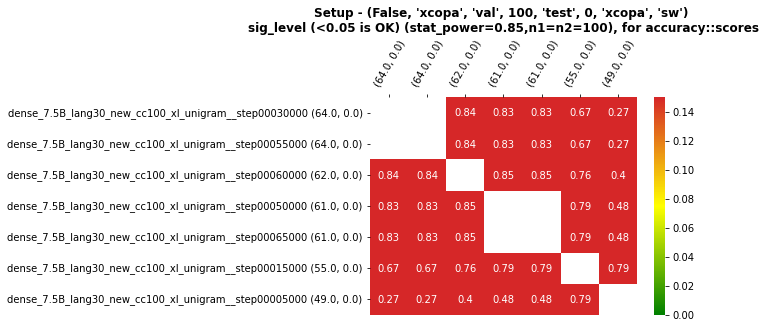

(False, 'xcopa', 'val', 100, 'test', 0, 'xcopa', 'ta')
p1=0.59, p2=0.59 - Cannot detect an effect-size of 0. Try changing your effect-size.
p1=0.59, p2=0.59 - Cannot detect an effect-size of 0. Try changing your effect-size.
p1=0.59, p2=0.59 - Cannot detect an effect-size of 0. Try changing your effect-size.


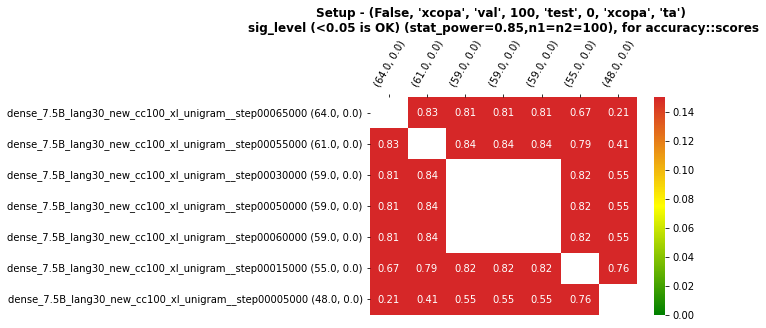

(False, 'xcopa', 'val', 100, 'test', 0, 'xcopa', 'th')
p1=0.65, p2=0.65 - Cannot detect an effect-size of 0. Try changing your effect-size.
p1=0.64, p2=0.64 - Cannot detect an effect-size of 0. Try changing your effect-size.
p1=0.64, p2=0.64 - Cannot detect an effect-size of 0. Try changing your effect-size.
p1=0.64, p2=0.64 - Cannot detect an effect-size of 0. Try changing your effect-size.


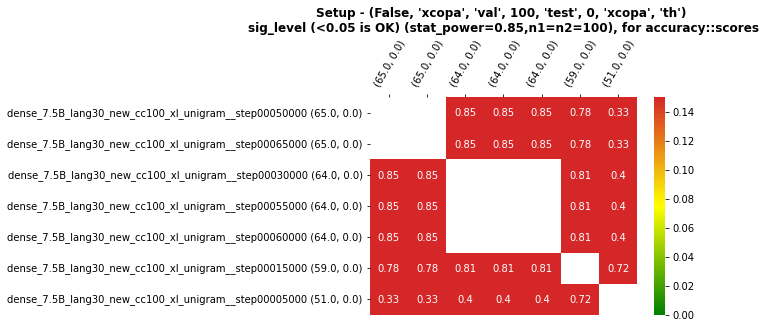

(False, 'xcopa', 'val', 100, 'test', 0, 'xcopa', 'tr')
p1=0.63, p2=0.63 - Cannot detect an effect-size of 0. Try changing your effect-size.
p1=0.62, p2=0.62 - Cannot detect an effect-size of 0. Try changing your effect-size.


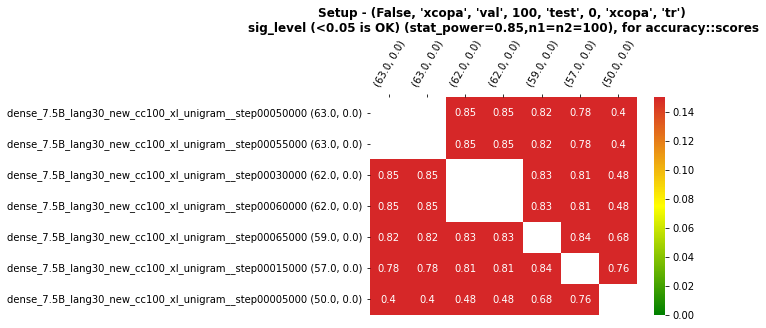

(False, 'xcopa', 'val', 100, 'test', 0, 'xcopa', 'vi')
p1=0.64, p2=0.64 - Cannot detect an effect-size of 0. Try changing your effect-size.


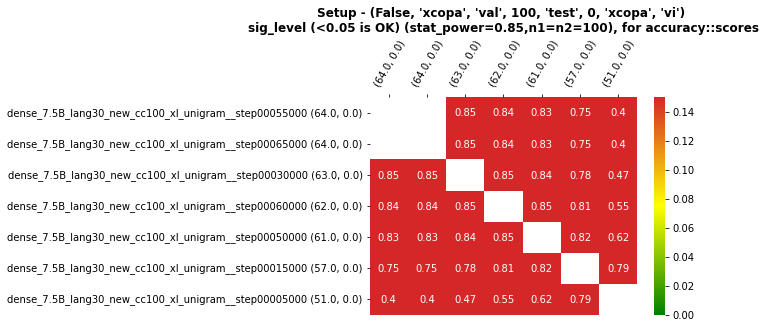

(False, 'xcopa', 'val', 100, 'test', 0, 'xcopa', 'zh')
p1=0.57, p2=0.57 - Cannot detect an effect-size of 0. Try changing your effect-size.
p1=0.57, p2=0.57 - Cannot detect an effect-size of 0. Try changing your effect-size.
p1=0.57, p2=0.57 - Cannot detect an effect-size of 0. Try changing your effect-size.


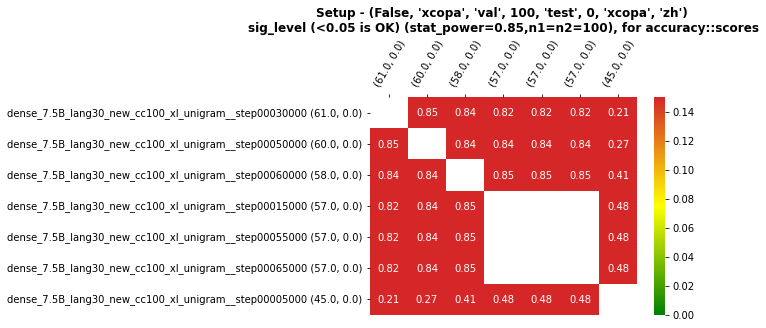

xwinograd
(False, 'xwinograd', 'test', 16, 'test', 0, 'winograd', 'zh')
p1=0.5, p2=0.5 - Cannot detect an effect-size of 0. Try changing your effect-size.
p1=0.5, p2=0.5 - Cannot detect an effect-size of 0. Try changing your effect-size.
p1=0.5, p2=0.5 - Cannot detect an effect-size of 0. Try changing your effect-size.
p1=0.5, p2=0.5 - Cannot detect an effect-size of 0. Try changing your effect-size.
p1=0.5, p2=0.5 - Cannot detect an effect-size of 0. Try changing your effect-size.
p1=0.5, p2=0.5 - Cannot detect an effect-size of 0. Try changing your effect-size.
p1=0.5, p2=0.5 - Cannot detect an effect-size of 0. Try changing your effect-size.
p1=0.5, p2=0.5 - Cannot detect an effect-size of 0. Try changing your effect-size.
p1=0.5, p2=0.5 - Cannot detect an effect-size of 0. Try changing your effect-size.
p1=0.5, p2=0.5 - Cannot detect an effect-size of 0. Try changing your effect-size.
p1=0.5, p2=0.5 - Cannot detect an effect-size of 0. Try changing your effect-size.
p1=0.5, p2=0.5 

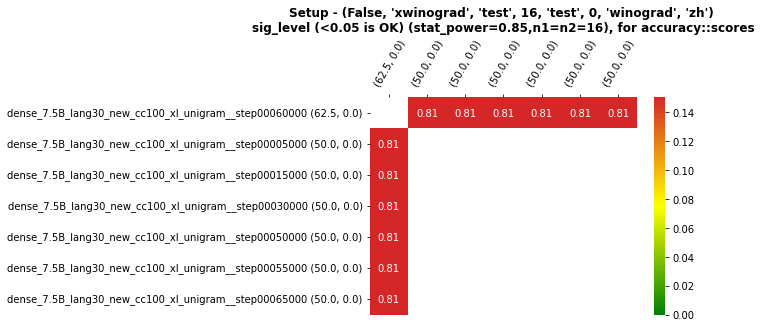

(False, 'xwinograd', 'test', 83, 'test', 0, 'winograd', 'fr')
p1=0.5542168674698795, p2=0.5542168674698795 - Cannot detect an effect-size of 0. Try changing your effect-size.


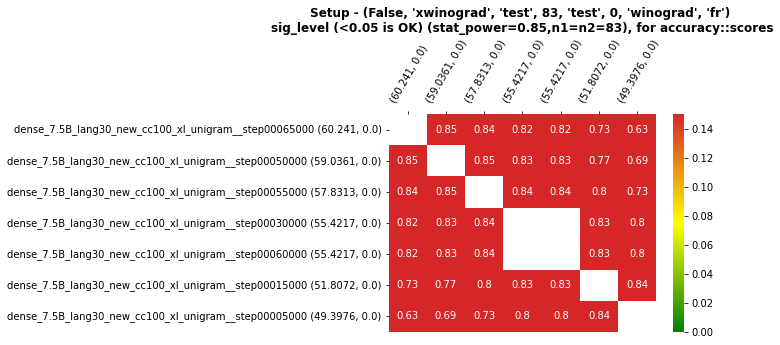

(False, 'xwinograd', 'test', 263, 'test', 0, 'winograd', 'pt')
p1=0.5741444866920152, p2=0.5741444866920152 - Cannot detect an effect-size of 0. Try changing your effect-size.


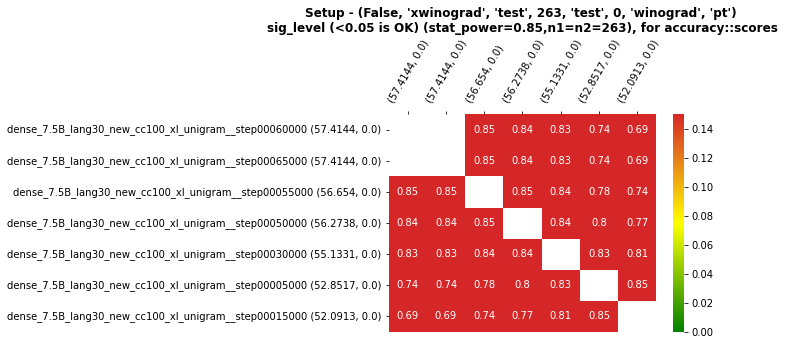

(False, 'xwinograd', 'test', 315, 'test', 0, 'winograd', 'ru')


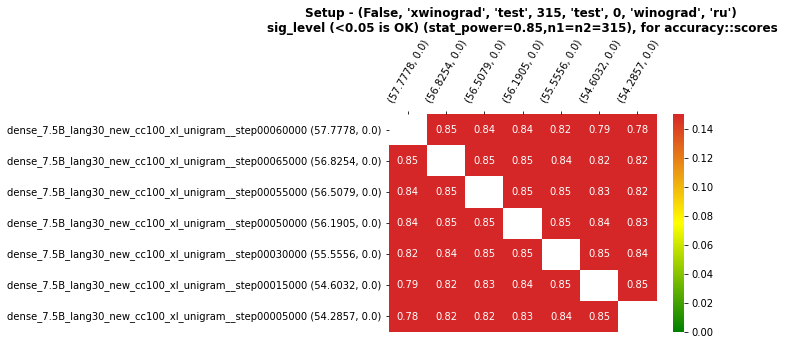

(False, 'xwinograd', 'test', 959, 'test', 0, 'winograd', 'jp')


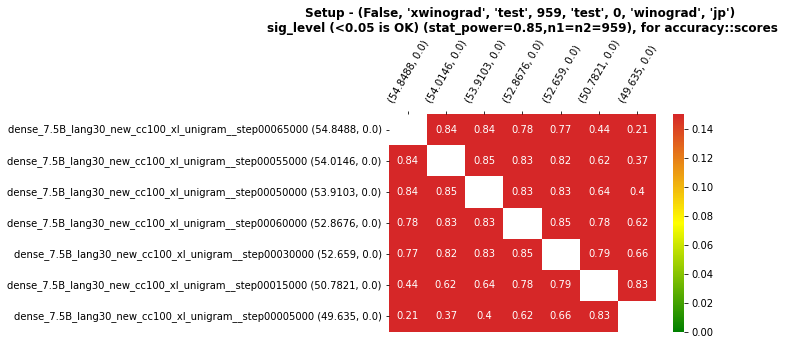

(False, 'xwinograd', 'test', 2325, 'test', 0, 'winograd', 'en')


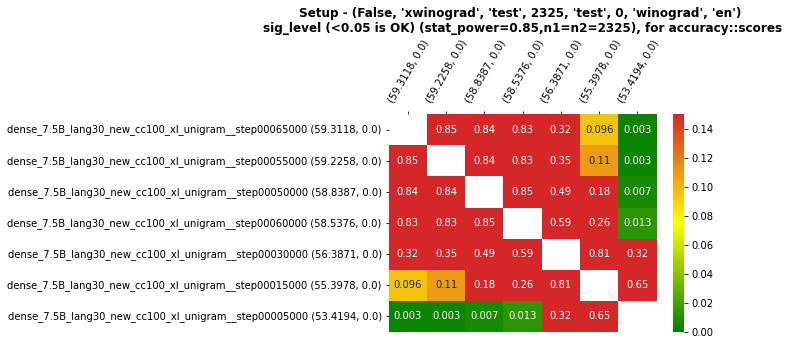

storycloze
(False, 'storycloze', 'val2016', 1871, 'val2016', 0, 'storycloze', 'ar')


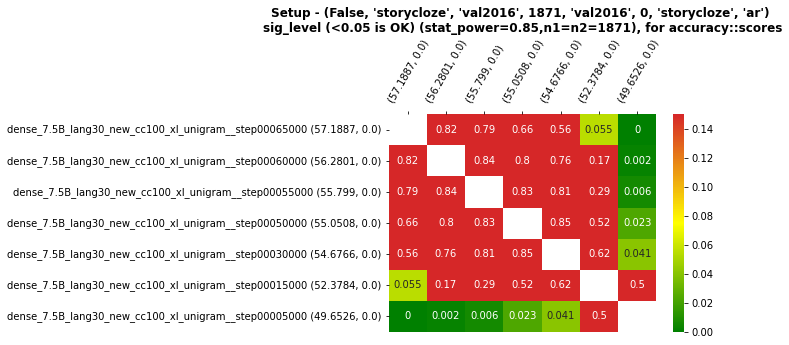

(False, 'storycloze', 'val2016', 1871, 'val2016', 0, 'storycloze', 'en')
p1=0.5879208979155532, p2=0.7252805986103688 - f(a) and f(b) must have different signs
p1=0.5879208979155532, p2=0.7247461250668091 - f(a) and f(b) must have different signs
p1=0.5879208979155532, p2=0.7161945483698556 - f(a) and f(b) must have different signs


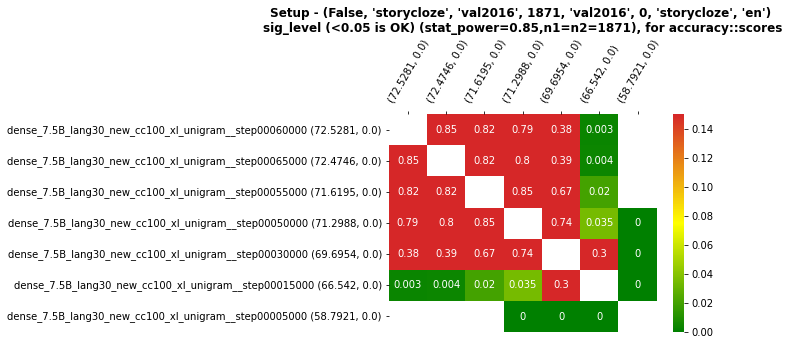

(False, 'storycloze', 'val2016', 1871, 'val2016', 0, 'storycloze', 'es')


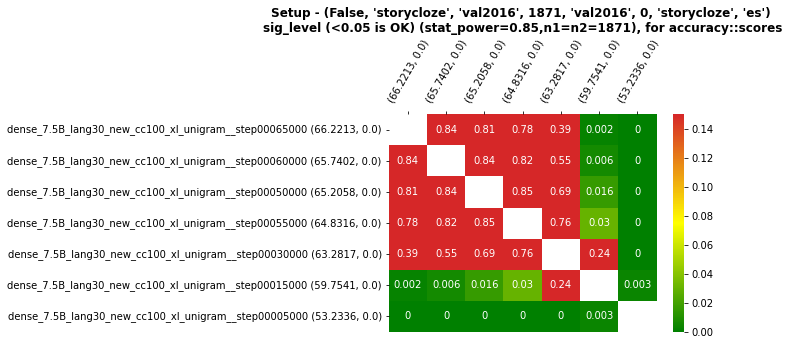

(False, 'storycloze', 'val2016', 1871, 'val2016', 0, 'storycloze', 'eu')


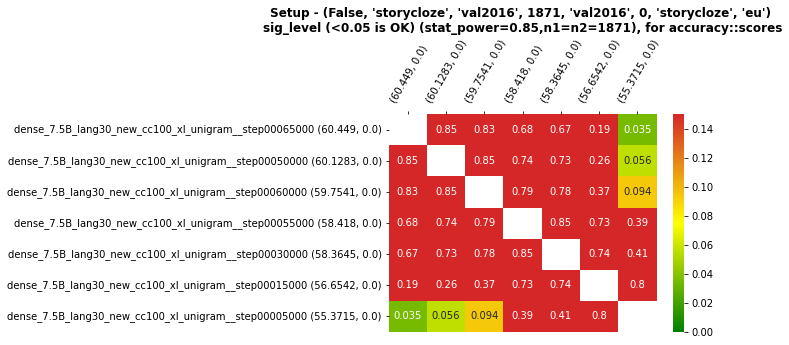

(False, 'storycloze', 'val2016', 1871, 'val2016', 0, 'storycloze', 'hi')


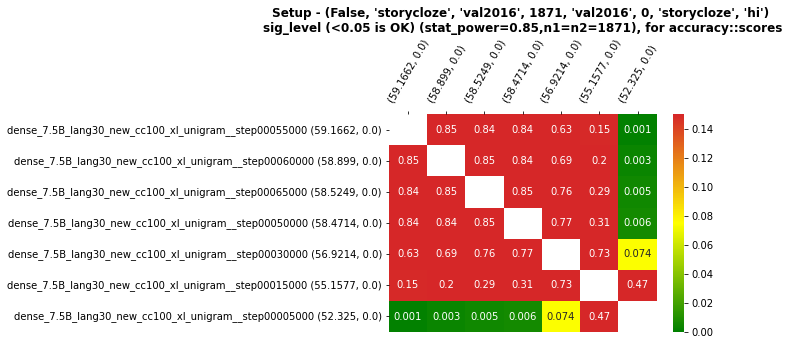

(False, 'storycloze', 'val2016', 1871, 'val2016', 0, 'storycloze', 'id')


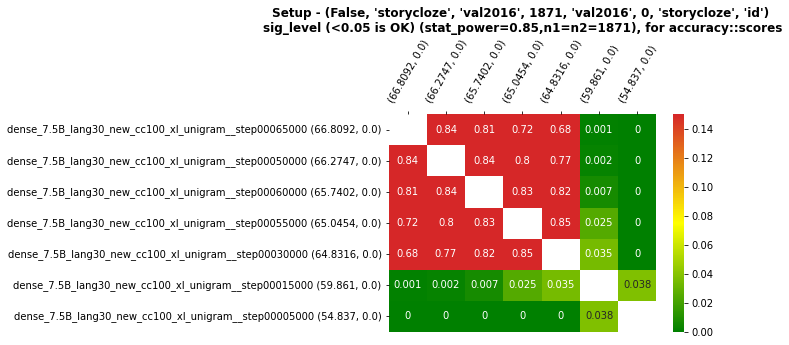

(False, 'storycloze', 'val2016', 1871, 'val2016', 0, 'storycloze', 'my')


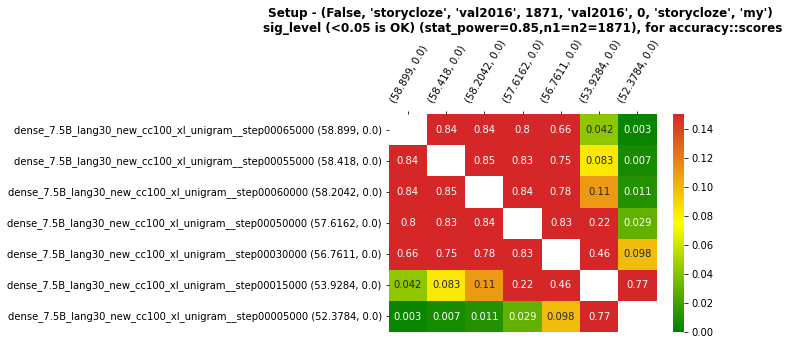

(False, 'storycloze', 'val2016', 1871, 'val2016', 0, 'storycloze', 'ru')


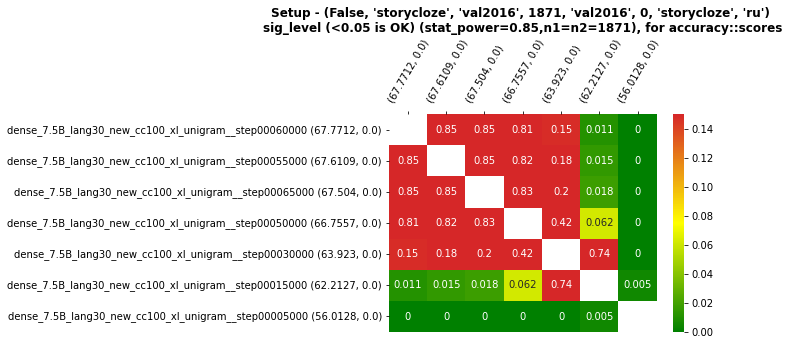

(False, 'storycloze', 'val2016', 1871, 'val2016', 0, 'storycloze', 'sw')


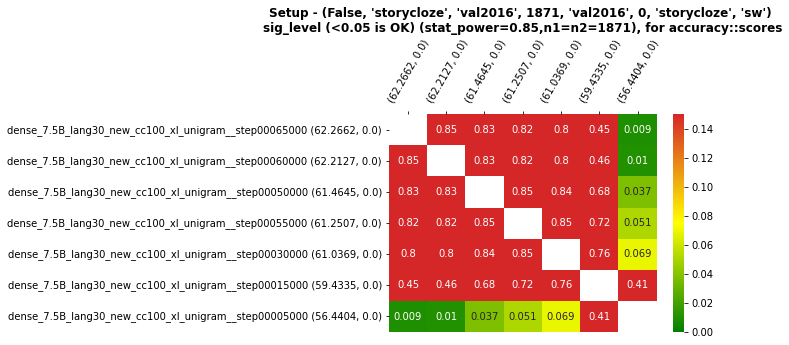

(False, 'storycloze', 'val2016', 1871, 'val2016', 0, 'storycloze', 'zh')
p1=0.6349545697487975, p2=0.6349545697487975 - Cannot detect an effect-size of 0. Try changing your effect-size.


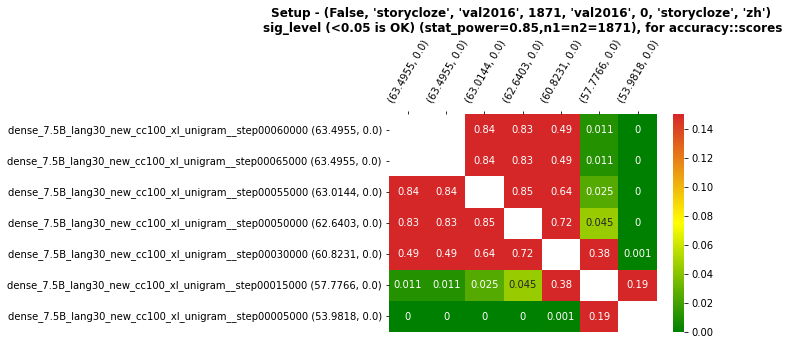

In [9]:
cmap_green_yellow_red = LinearSegmentedColormap.from_list(
    name='test', 
    colors=['green','yellow','tab:red']
)

tasks = list(set(df["task"]))
tasks

use_mean_score = True # 

for task in tasks:
    print(task)
    df_task = df[df["task"] == task]
    #df_task = df_task[df_task["eval_examples_cnt"]]
    
    value_cols = "accuracy::scores"
    #value_cols = "accuracy_mean::scores"
    index_cols = ["calibration", "task", "eval_set", "eval_examples_cnt", "train_set", "nb_few_shot_samples", 
              "template", "language",
             ]
    cols = [ "model_name"]
    
    pt = pd.pivot_table(df_task, values=value_cols, index=index_cols,
                    columns=cols, aggfunc=lambda x: x)
    #print(pt)
    for setup_idx, row in pt.iterrows():
        warnings.filterwarnings("ignore")
        print(setup_idx) 
        eval_set_examples = setup_idx[3]
        models_cnt = len([x for x in row.iteritems()])
        significance_matrix = -np.ones((models_cnt, models_cnt))
        model_scores = [(model0, scores0 if isinstance(scores0, list) else [scores0]) for model0, scores0 in row.iteritems()]
        model_scores.sort(key=lambda x: np.mean(x[1]), reverse=True)
        model_labels_y_axis = [f"{x[0]} {(np.round(np.mean(x[1]),4), np.round(np.std(x[1]),4))}" for x in model_scores]
        model_labels_x_axis = [f" {(np.round(np.mean(x[1]),4), np.round(np.std(x[1]),4))}" for x in model_scores]
        for i0, (model0, scores0) in enumerate(model_scores):
            for i1, (model1, scores1) in enumerate(model_scores):
                if i1 >= i0:
                    continue
                    
                if not isinstance(scores0, list):
                    scores0 = [scores0]
                if not isinstance(scores1, list):
                    scores1 = [scores1]
                    
                if len(scores0) != len(scores1):
                    print(f"Different number of evals {model0}({len(scores0)}) {model1}({len(scores1)}).")
                    continue
                
                    
                overall_sig_level = (-1.0, 0.0)
                
                try:
                    score0, score0_std = np.mean(scores0), np.std(scores0)
                    score1, score1_std = np.mean(scores1), np.std(scores1)

                    if np.isnan(score0) or np.isnan(score1):
                        continue

                    if score0 > 1.0:
                        score0 = score0 / 100.00
                    if score1 > 1.0:
                        score1 = score1 / 100.00
                        
                    sig_level, suggestions = ProportionSignificanceTest().solve(
                                n1=eval_set_examples, n2=eval_set_examples, p1=score0, p2=score1, power=min_stat_power, sig_level=None
                            ) 
                    overall_sig_level = (sig_level, 0.0)
                except Exception as e:
                        print(f"p1={score0}, p2={score1} - {e}")
                significance_matrix[i0, i1] = overall_sig_level[0]
                significance_matrix[i1, i0] = overall_sig_level[0]
        #plt.imshow(1-significance_matrix, cmap=plt.cm.viridis)
        sig_matrix_mask = significance_matrix < 0
        significance_matrix = np.around(significance_matrix, 3)
        ax = sns.heatmap(significance_matrix, 
                    mask=sig_matrix_mask, 
                    xticklabels=model_labels_x_axis,
                    yticklabels=model_labels_y_axis,
                    vmin=0.00,
                    vmax=3*max_sig_level,
                    annot=True,
                    cmap=cmap_green_yellow_red)
        plt.yticks(rotation=0)
        ax.tick_params(axis='x', rotation=60)
        ax.xaxis.tick_top() # x axis on top
        ax.xaxis.set_label_position('top')
        ax.set_title(f"Setup - {setup_idx} \n"
                     + f"sig_level (<{max_sig_level} is OK) (stat_power={min_stat_power},n1=n2={eval_set_examples}), for {value_cols}", weight='bold')
        
        plt.show()
        #break # debug
    #break # debug
#pt
#print(significance_matrix)

# Make your view available to others
If you think that you created a view that might be useful to others, you can add it to the collect_results.py.
Simply add the `my_custom_view` function to the `display_views` dictionary in [collect_results.py](examples/few_shot/scripts/collect_results.py) and the custom view will be available as -v my_custom_view_freindly.

In [10]:
np.zeros([2,3])

array([[0., 0., 0.],
       [0., 0., 0.]])

In [11]:
#df[df["run_params::train_sep"] == "\n\n"]